In [1]:
from netCDF4 import Dataset
import matplotlib.pyplot as plt
import numpy as np
import torch

DEVICE = 'cuda:0'

%matplotlib notebook

In [2]:
CROP = 'maize'
YEAR = 2010

In [3]:
ds = Dataset(f'cropYield/{CROP}/yield_{YEAR}.nc4')
ds

<class 'netCDF4._netCDF4.Dataset'>
root group (NETCDF4 data model, file format HDF5):
    dimensions(sizes): lon(720), lat(360)
    variables(dimensions): float64 lon(lon), float64 lat(lat), float32 var(lat, lon)
    groups: 

In [5]:
e = ds['var']

In [6]:
import numpy as np
r1 = e[:].data
m = e[:].mask
r = np.where(~m, r1, np.nan)

In [7]:
np.sum(~m)

15086

In [60]:
def plot_on_map(data, vmin=-1.96, vmax=1.96, cmap='cividis', ax=None):
    lat, lon = ds['lat'], ds['lon']
    lat, lon = lat[:], lon[:]
    lat.data[0]
    if ax is None:
        fig = plt.figure()
        ax = plt.axes(projection=ccrs.Robinson())
    img_extent = (lon[0], lon[-1], lat[0], lat[-1])
    im = ax.imshow(data, origin='lower', extent=img_extent, transform=ccrs.PlateCarree(), cmap=cmap,
                  vmin=vmin, vmax=vmax)
    ax.coastlines()
    ax.set_title('Global yield')
    #cax = fig.add_axes([ax.get_position().x1+1,ax.get_position().y0,0.02,ax.get_position().height])
    cax = ax.inset_axes((1.1, 0, .05, 1))
    plt.colorbar(im, cax=cax) # Similar to fig.colorbar(im, cax = cax)
    if ax is None:
        fig.tight_layout()

In [9]:
plt.rcParams['figure.figsize'] = (9, 6)

Check if the data is yield or yield per hectar

<IPython.core.display.Javascript object>


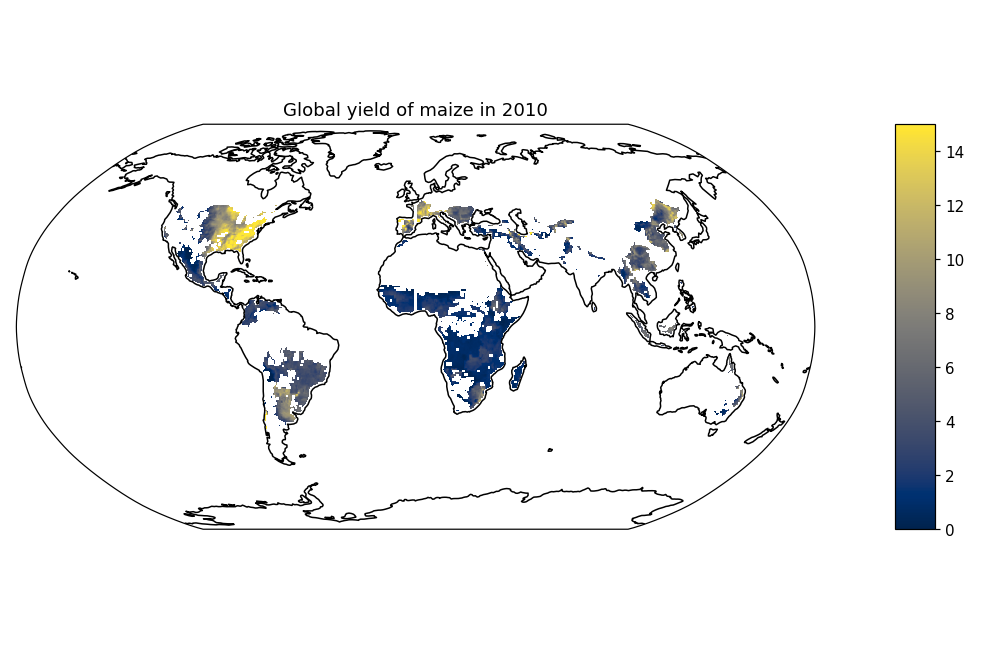

In [10]:
import cartopy
import cartopy.crs as ccrs
plot_on_map(r, vmin=0, vmax=15, cmap='cividis')
plt.title(f'Global yield of {CROP} in {YEAR}')
plt.tight_layout()
plt.savefig(f'fig_example_{CROP}.jpg', dpi=800)

In [11]:
data_train = np.arange(1981, 2017)
years = data_train[(np.mod(data_train, 10) != 5) & (np.mod(data_train, 10) != 6)]
years_val = data_train[np.mod(data_train, 10) == 5]
years_test = data_train[np.mod(data_train, 10) == 6]
LOG = False


def build_features_targets(years, remove_nan: bool = True, return_lat_lon: bool = False, add_year: bool = True,
                          log: bool = LOG):
    features, targets = [], []

    for year in years:
        data_year = Dataset(f'cropYield/{CROP}/yield_{year}.nc4')
        yields = data_year['var'][:].data
        missing = data_year['var'][:].mask
        # consider zero yields as outliers
        missing[yields == 0] = True
        lat = data_year['lat'][:].data
        lon = data_year['lon'][:].data
        lat, lon = np.meshgrid(lat, lon, indexing='ij')
        if remove_nan:
            year_array = year * np.ones(np.sum(~missing))
            if add_year:
                data_flat = (np.stack((lat[~missing].flatten(), lon[~missing].flatten(), year_array), axis=-1), 
                             yields[~missing].flatten())
            else:
                data_flat = (np.stack((lat[~missing].flatten(), lon[~missing].flatten()), axis=-1), 
                             yields[~missing].flatten())
        else:
            yields[missing] = np.nan
            year_array = year * np.ones(yields.shape[0] * yields.shape[1])
            if add_year:
                data_flat = (np.stack((lat.flatten(), lon.flatten(), year_array), axis=-1), yields.flatten())
            else:
                data_flat = (np.stack((lat.flatten(), lon.flatten()), axis=-1), yields.flatten())
        features.append(data_flat[0])
        print(year, np.any(data_flat[1] == 0))
        print(np.nanmin(data_flat[1]))
        if log:
            targets.append(np.log(data_flat[1]))
        else:
            targets.append(data_flat[1])

    features = np.concatenate(features)
    targets = np.concatenate(targets).reshape((-1, 1))
    if return_lat_lon:
        return features, targets, lat, lon
    return features, targets

features, targets, lat, lon = build_features_targets(years, return_lat_lon=True)
features_val, targets_val = build_features_targets(years_val, remove_nan=False)
features_test, targets_test = build_features_targets(years_test, remove_nan=False)

1981 False
0.00057772093
1982 False
0.015971828
1983 False
0.013076004
1984 False
0.012754147
1987 False
0.016099848
1988 False
0.021048555
1989 False
0.020386538
1990 False
0.017072363
1991 False
0.024727724
1992 False
0.016046463
1993 False
0.022176208
1994 False
0.02722064
1997 False
0.030491043
1998 False
0.02099506
1999 False
0.015040825
2000 False
0.02377931
2001 False
0.018225472
2002 False
0.022765636
2003 False
0.030929456
2004 False
0.026029734
2007 False
0.0009889603
2008 False
3.118813e-05
2009 False
0.0148867965
2010 False
0.012977362
2011 False
0.0005068183
2012 False
0.00437361
2013 False
0.0103171915
2014 False
0.0028457642
1985 False
0.02089654
1995 False
0.020337237
2005 False
0.0071664006
2015 False
0.005948171
1986 False
0.016557569
1996 False
0.02775478
2006 False
0.0103250295
2016 False
0.0024855137


In [12]:
mean_features, std_features = np.mean(features, axis=0), np.std(features, axis=0)
mean_targets, std_targets = np.mean(targets), np.std(targets)

features = (features - np.mean(features, axis=0)) / np.std(features, axis=0)
targets = (targets - np.mean(targets)) / np.std(targets)

features_val = (features_val - mean_features) / std_features
targets_val = (targets_val - mean_targets) / std_targets
features_val = torch.from_numpy(features_val).to(dtype=torch.float32, device=DEVICE)
targets_val = torch.from_numpy(targets_val).to(dtype=torch.float32, device=DEVICE)

features_test = (features_test - mean_features) / std_features
targets_test = (targets_test - mean_targets) / std_targets
features_test = torch.from_numpy(features_test).to(dtype=torch.float32, device=DEVICE)
targets_test = torch.from_numpy(targets_test).to(dtype=torch.float32, device=DEVICE)

In [13]:
years

array([1981, 1982, 1983, 1984, 1987, 1988, 1989, 1990, 1991, 1992, 1993,
       1994, 1997, 1998, 1999, 2000, 2001, 2002, 2003, 2004, 2007, 2008,
       2009, 2010, 2011, 2012, 2013, 2014])

In [14]:
years_val

array([1985, 1995, 2005, 2015])

In [15]:
years_test

array([1986, 1996, 2006, 2016])

### Define neural nets 

In [16]:
from tukey.models import NN
from torch.nn import Module, Linear, ReLU
from copy import deepcopy
from torch.nn import BatchNorm1d, Sequential


class NN(Sequential):
    def __init__(self, structure: list, n_out: int, batch_norm: bool = False):
        subblocks = []
        self.n_out = n_out
        self.batch_norm = batch_norm
        for i in range(len(structure) - 1):
            subblocks.extend(self._make_sublock(structure[i], structure[i + 1]))
        subblocks.extend(self._make_final_layer(structure[-1]))
        super().__init__(*subblocks)

    def _make_sublock(self, n_in: int, n_out: int):
        if not self.batch_norm:
            return [Linear(n_in, n_out), ReLU()]
        return [Linear(n_in, n_out), ReLU(), BatchNorm1d(n_out)]

    def _make_final_layer(self, n_in : int):
        return [Linear(n_in, self.n_out), ]

s = 256
nn_base = NN((2, s, s, s, s, s), s, batch_norm=True)
nn_base2 = NN((2, s, s, s, s, s), s, batch_norm=True)


class NNyear(Module):
    def __init__(self, nn, out=4):
        super().__init__()
        self.nn = nn
        self.l = Linear(s + 1, 64)
        self.l2 = Linear(64, out)
        self.relu = ReLU()

    def forward(self, input):
        out1 = self.nn(input[..., :2])
        out2 = self.relu(torch.cat((out1, input[..., 2:]), dim=-1))
        out3 = self.relu(self.l(out2))
        return self.l2(out3)

nn = NNyear(nn_base)
nn_gaussian = NNyear(nn_base2, out=2)

#nn = nn_base
#nn_gaussian = NN((2, 256, 256, 256, 256), 2)

nn = nn.to(device=DEVICE)
nn_gaussian = nn_gaussian.to(device=DEVICE)

In [17]:
nn, nn_gaussian

(NNyear(
   (nn): NN(
     (0): Linear(in_features=2, out_features=256, bias=True)
     (1): ReLU()
     (2): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
     (3): Linear(in_features=256, out_features=256, bias=True)
     (4): ReLU()
     (5): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
     (6): Linear(in_features=256, out_features=256, bias=True)
     (7): ReLU()
     (8): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
     (9): Linear(in_features=256, out_features=256, bias=True)
     (10): ReLU()
     (11): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
     (12): Linear(in_features=256, out_features=256, bias=True)
     (13): ReLU()
     (14): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
     (15): Linear(in_features=256, out_features=256, bias=True)
   )
   (l): Linear(in_features=257, out_features=64, bi

### Define losses

In [18]:
from tukey.losses import TuckeyGandHloss, GaussianLoss
loss = TuckeyGandHloss(1)
loss_gaussian = GaussianLoss(1)

### Training 

In [19]:
from torch.utils.data import TensorDataset, DataLoader

torch_ds = TensorDataset(torch.from_numpy(features).to(dtype=torch.float32, device=DEVICE), 
                         torch.from_numpy(targets).to(dtype=torch.float32, device=DEVICE))

sel = ~torch.isnan(targets_val).flatten()
torch_ds_val = TensorDataset(features_val[sel, :], targets_val[sel])

In [58]:
from torch.optim import Adam
from torch.optim.lr_scheduler import MultiStepLR

# start with lr = 1e-4
lr = 1e-4
optimizer = Adam(nn.parameters(), lr=lr)
optimizer_gaussian = Adam(nn_gaussian.parameters(), lr=lr)

scheduler = MultiStepLR(optimizer, milestones=[10, 15, 20, 30, 40], verbose=True)
scheduler_gaussian = MultiStepLR(optimizer_gaussian,milestones=[10, 15, 20, 30, 40], verbose=True)

Adjusting learning rate of group 0 to 1.0000e-04.
Adjusting learning rate of group 0 to 1.0000e-04.


<IPython.core.display.Javascript object>


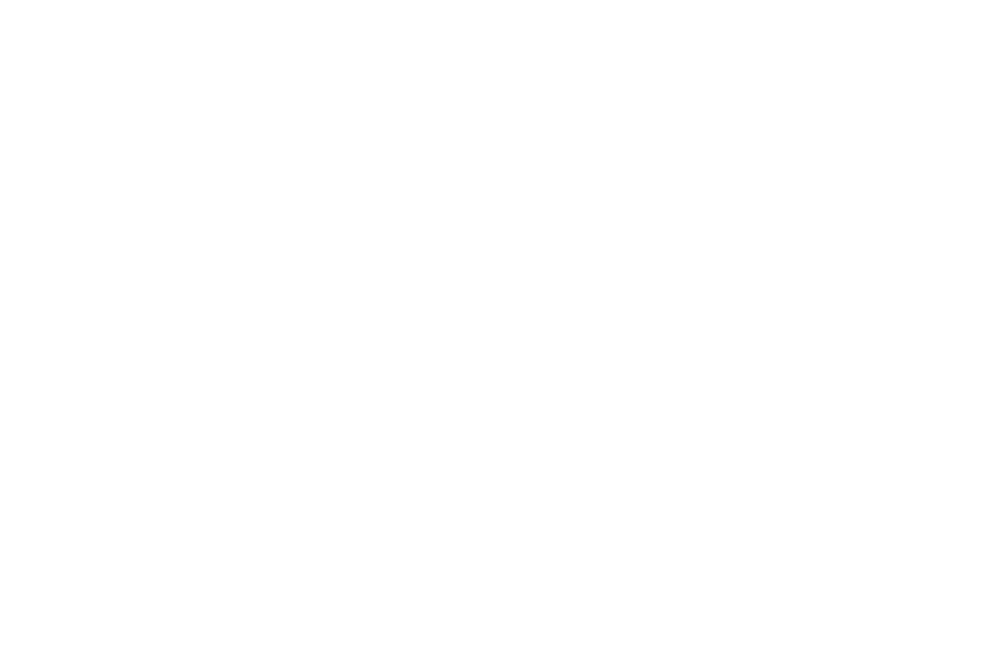

<IPython.core.display.Javascript object>


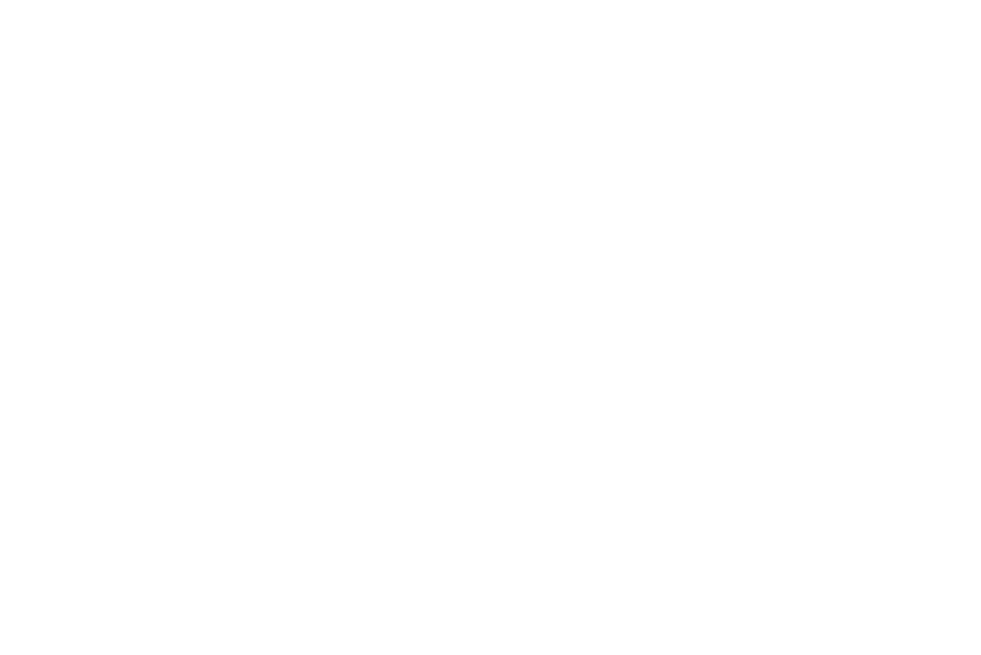

<IPython.core.display.Javascript object>


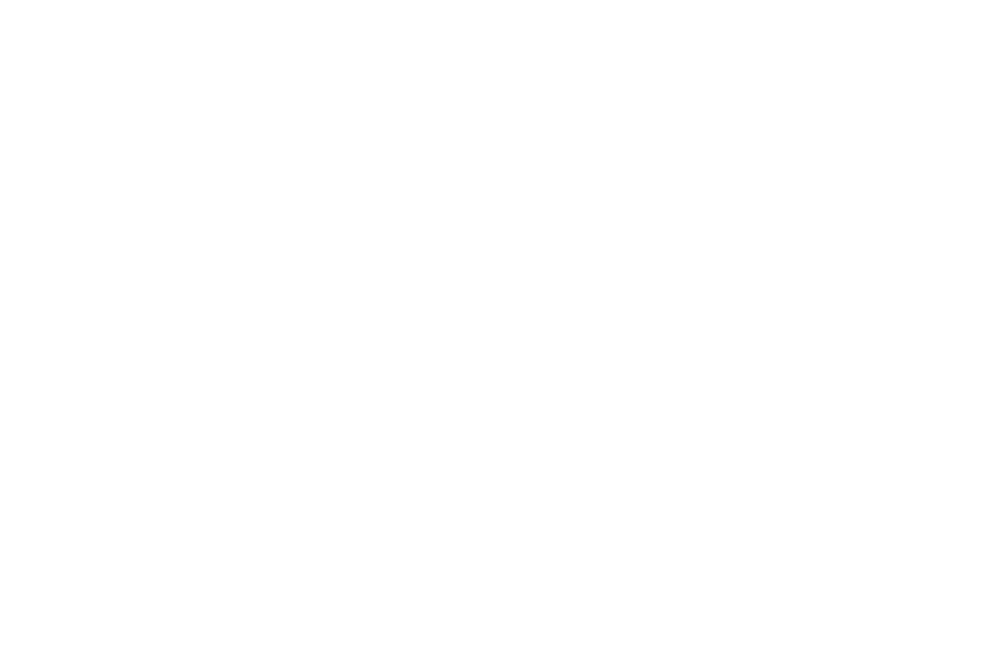

<IPython.core.display.Javascript object>


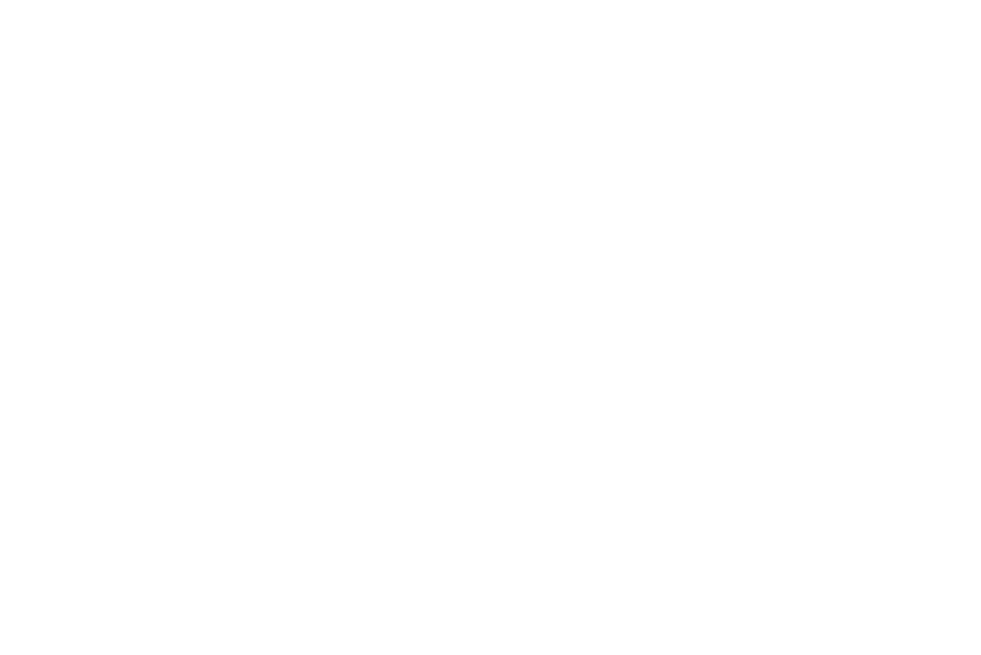

<IPython.core.display.Javascript object>


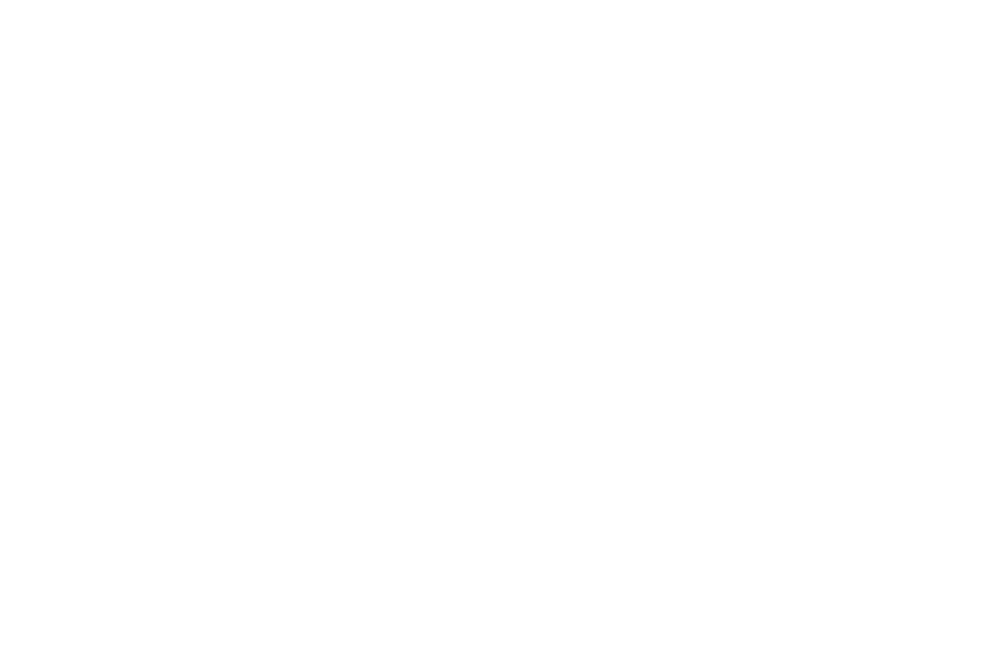

<IPython.core.display.Javascript object>


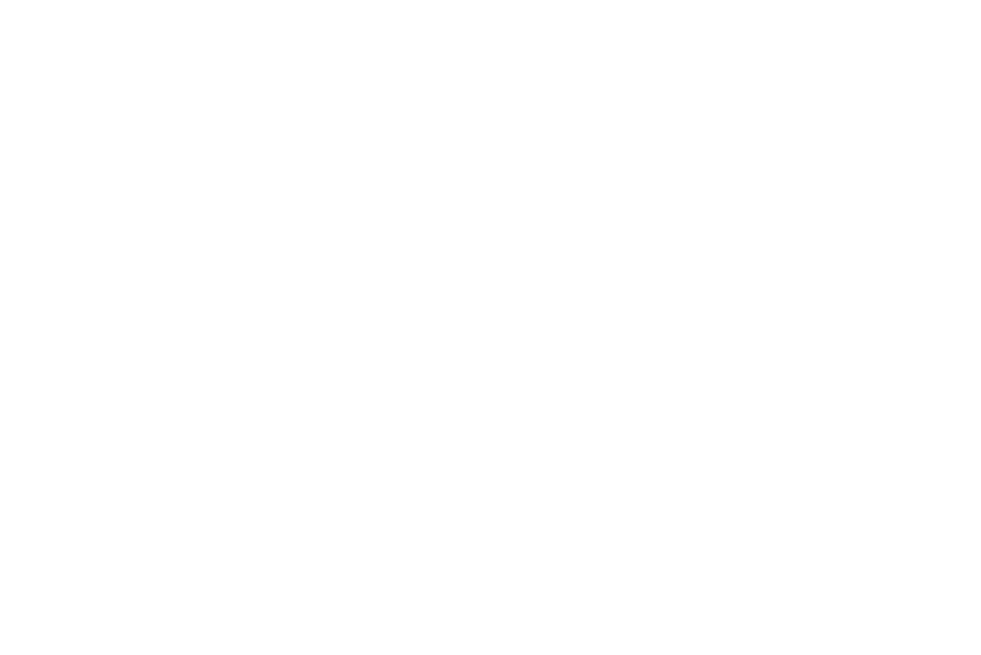

<IPython.core.display.Javascript object>


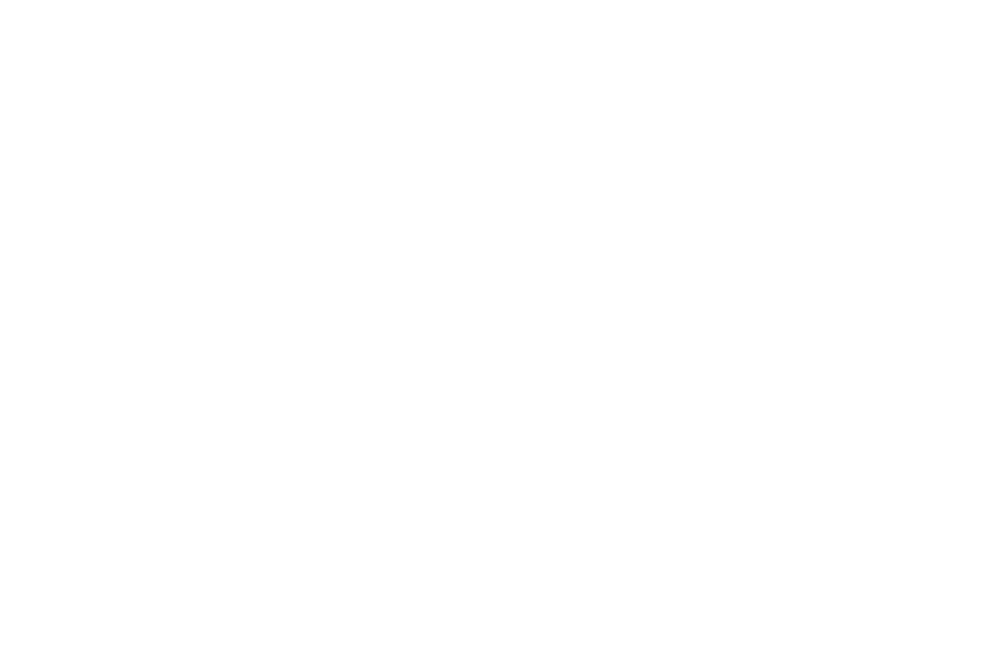

<IPython.core.display.Javascript object>


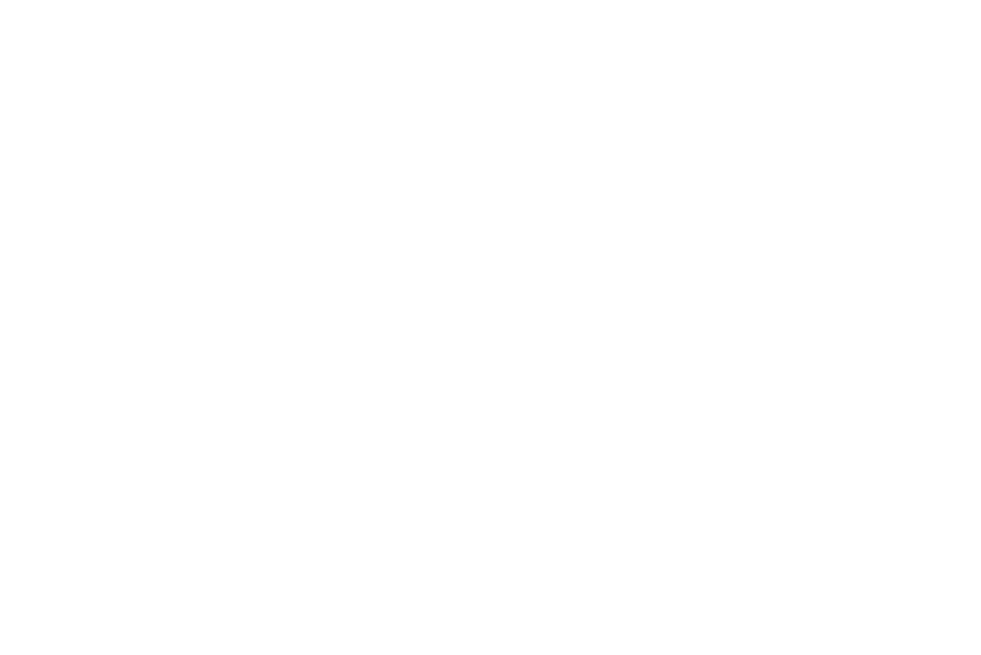

<IPython.core.display.Javascript object>


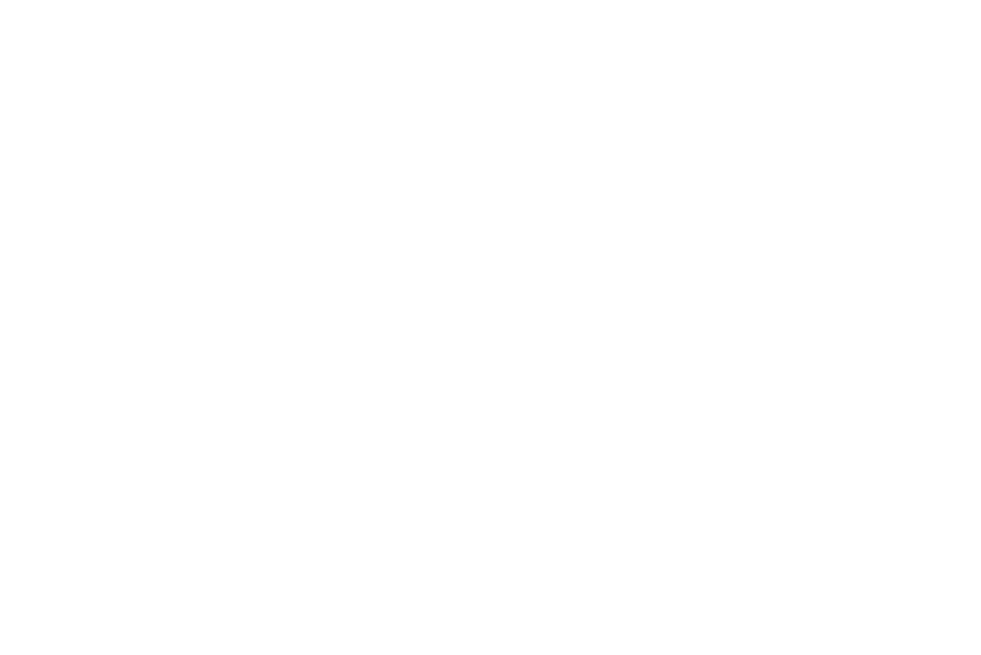

<IPython.core.display.Javascript object>


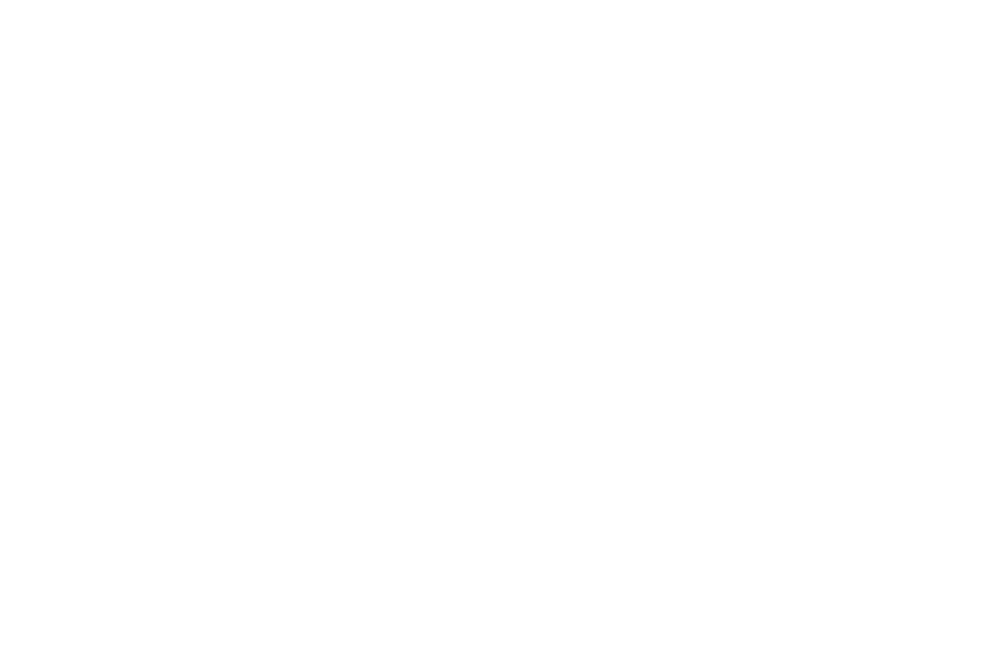

<IPython.core.display.Javascript object>


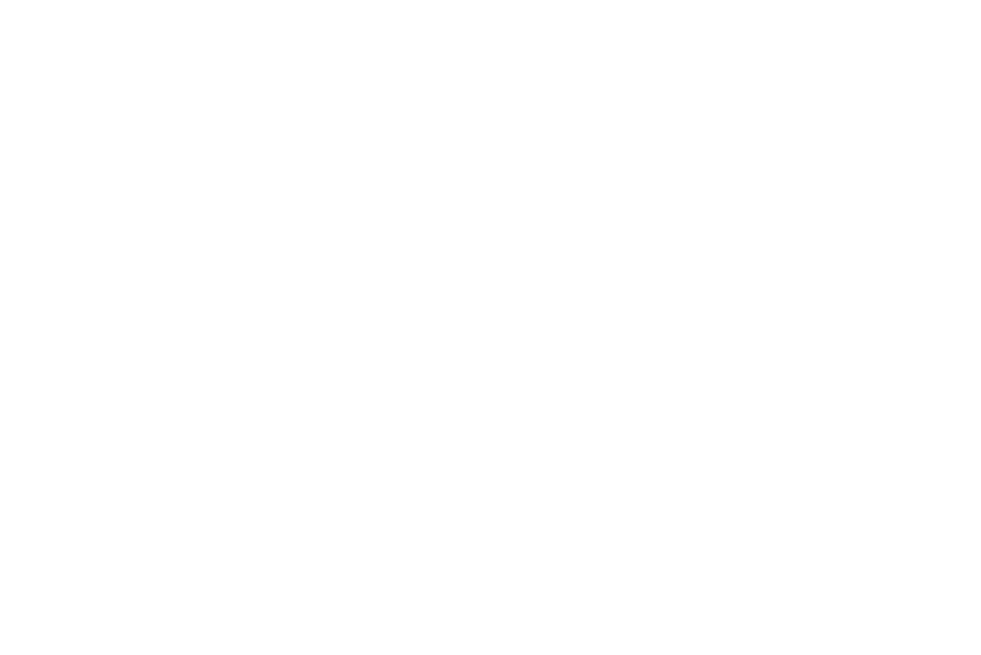

<IPython.core.display.Javascript object>


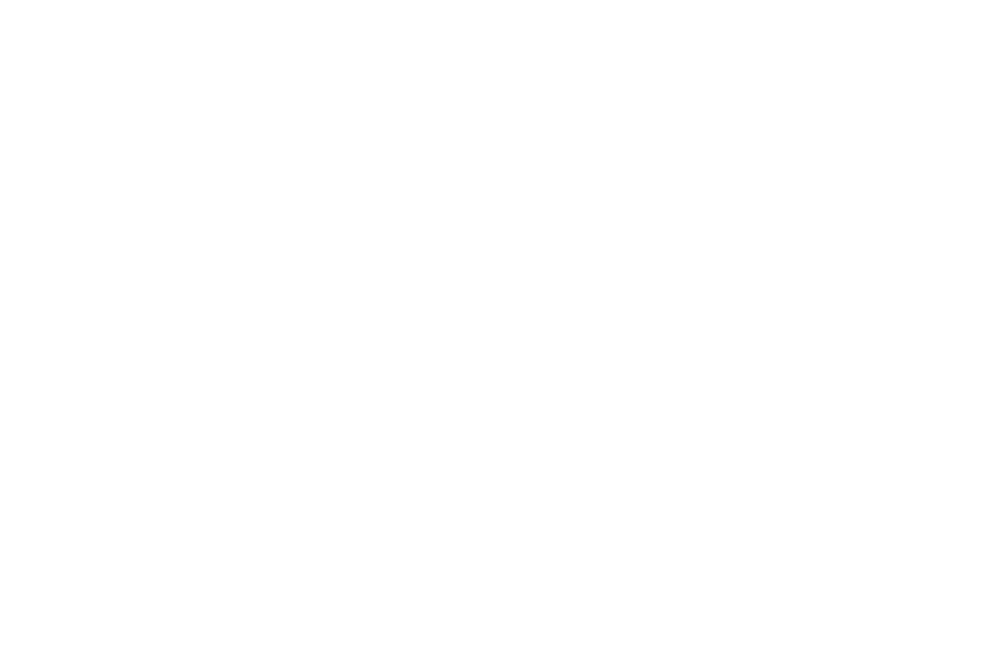

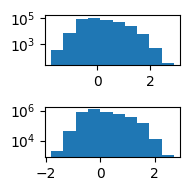

Adjusting learning rate of group 0 to 1.0000e-04.
(0.2288093810889825, 0.37392152778535004)


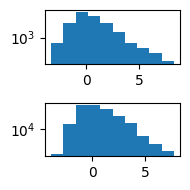

Adjusting learning rate of group 0 to 1.0000e-04.
(0.02093318299143519, 0.2183393412283678)
---


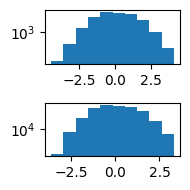

Adjusting learning rate of group 0 to 1.0000e-04.
(-0.34124563472816744, -0.3685894585158451)


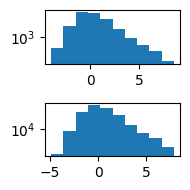

Adjusting learning rate of group 0 to 1.0000e-04.
(-0.319419127092304, -0.3403634459498417)
---


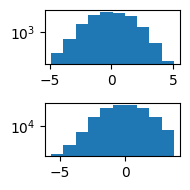

Adjusting learning rate of group 0 to 1.0000e-04.
(-0.4702581863805472, -0.5047980471547827)


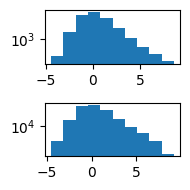

Adjusting learning rate of group 0 to 1.0000e-04.
(-0.3741176106843604, -0.4062308266938451)
---


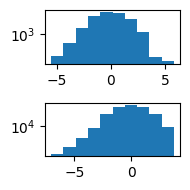

Adjusting learning rate of group 0 to 1.0000e-04.
(-0.5202483530324625, -0.5625044437776129)


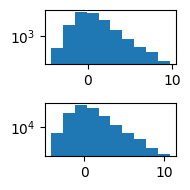

Adjusting learning rate of group 0 to 1.0000e-04.
(-0.42993738547147037, -0.46810098800314476)
---


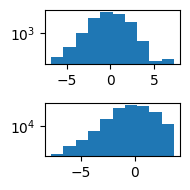

Adjusting learning rate of group 0 to 1.0000e-04.
(-0.5451409055525998, -0.5831755327891155)


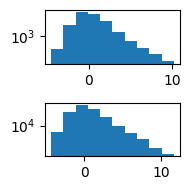

Adjusting learning rate of group 0 to 1.0000e-04.
(-0.44235350245452787, -0.4801333345562579)
---


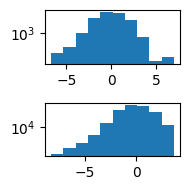

Adjusting learning rate of group 0 to 1.0000e-04.
(-0.5755074476621237, -0.61260300084769)


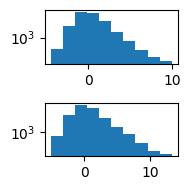

Adjusting learning rate of group 0 to 1.0000e-04.
(-0.4408068132687764, -0.4716180512704045)
---


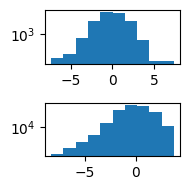

Adjusting learning rate of group 0 to 1.0000e-04.
(-0.5918807157550949, -0.6301974144326635)


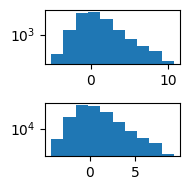

Adjusting learning rate of group 0 to 1.0000e-04.
(-0.49527162528899776, -0.5294882820313236)
---


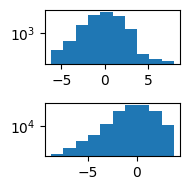

Adjusting learning rate of group 0 to 1.0000e-04.
(-0.6031090990606561, -0.6358923696609865)


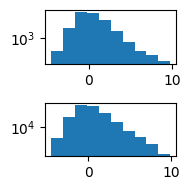

Adjusting learning rate of group 0 to 1.0000e-04.
(-0.503571922341025, -0.5468173034219856)
---


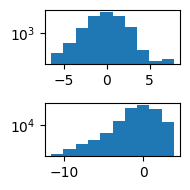

Adjusting learning rate of group 0 to 1.0000e-04.
(-0.6206337130931486, -0.6553008944155222)


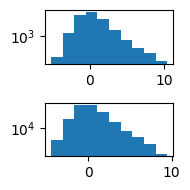

Adjusting learning rate of group 0 to 1.0000e-04.
(-0.5084867319428777, -0.547762132911797)
---


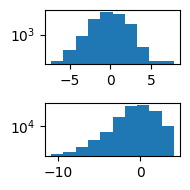

Adjusting learning rate of group 0 to 1.0000e-05.
(-0.6278034427079809, -0.654879018484828)


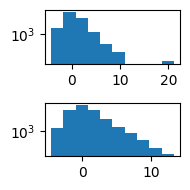

Adjusting learning rate of group 0 to 1.0000e-05.
(-0.5048928601914141, -0.5680789405322937)
---


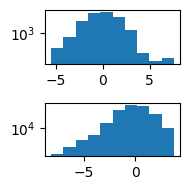

Adjusting learning rate of group 0 to 1.0000e-05.
(-0.6743603399000972, -0.7228188780416925)


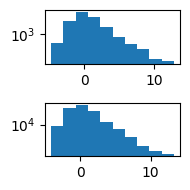

Adjusting learning rate of group 0 to 1.0000e-05.
(-0.5302171432469265, -0.5761002528380199)
---


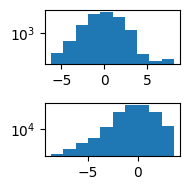

Adjusting learning rate of group 0 to 1.0000e-05.
(-0.6858046679611666, -0.738817727709391)


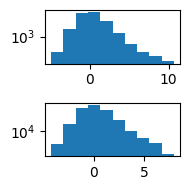

Adjusting learning rate of group 0 to 1.0000e-05.
(-0.5923165470720774, -0.6451986525432173)
---


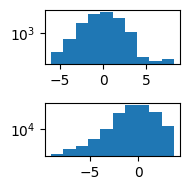

Adjusting learning rate of group 0 to 1.0000e-05.
(-0.6881103824420147, -0.7432901801833187)


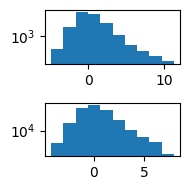

Adjusting learning rate of group 0 to 1.0000e-05.
(-0.6013410850820771, -0.6594186719641628)
---


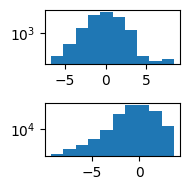

Adjusting learning rate of group 0 to 1.0000e-05.
(-0.6904263270188526, -0.7450516676328268)


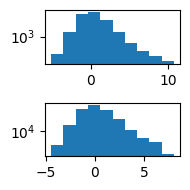

Adjusting learning rate of group 0 to 1.0000e-05.
(-0.6140973406383791, -0.66825610901936)
---


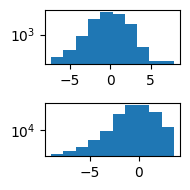

Adjusting learning rate of group 0 to 1.0000e-06.
(-0.6937937732920589, -0.7461675333689495)


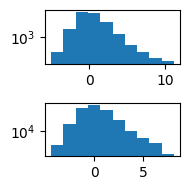

Adjusting learning rate of group 0 to 1.0000e-06.
(-0.6098129056977579, -0.670896271625197)
---


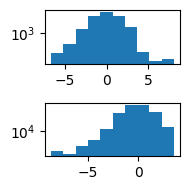

Adjusting learning rate of group 0 to 1.0000e-06.
(-0.6974428091422621, -0.751683788845338)


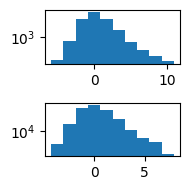

Adjusting learning rate of group 0 to 1.0000e-06.
(-0.6199862149106451, -0.6778491699551962)
---


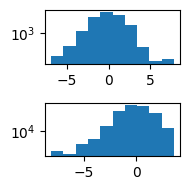

Adjusting learning rate of group 0 to 1.0000e-06.
(-0.7015920859503458, -0.7567916893097292)


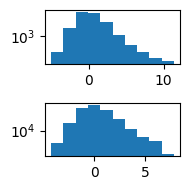

Adjusting learning rate of group 0 to 1.0000e-06.
(-0.6129460291690138, -0.6806711583252413)
---


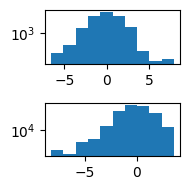

Adjusting learning rate of group 0 to 1.0000e-06.
(-0.7045500989419868, -0.7573902190449726)


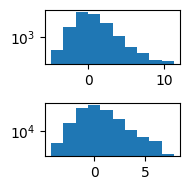

Adjusting learning rate of group 0 to 1.0000e-06.
(-0.6244046117167875, -0.681128298661795)
---


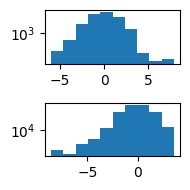

Adjusting learning rate of group 0 to 1.0000e-06.
(-0.7039535052805062, -0.7579888371099909)


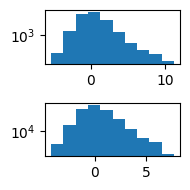

Adjusting learning rate of group 0 to 1.0000e-06.
(-0.6253705997783018, -0.682794991027878)
---


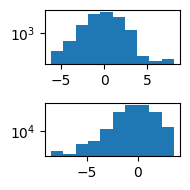

Adjusting learning rate of group 0 to 1.0000e-07.
(-0.702131212116724, -0.7588654433388308)


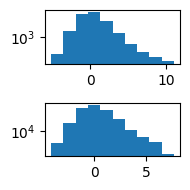

Adjusting learning rate of group 0 to 1.0000e-07.
(-0.6233817322785595, -0.6833764846066395)
---


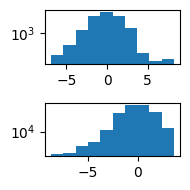

Adjusting learning rate of group 0 to 1.0000e-07.
(-0.7058176078710211, -0.757996101695371)


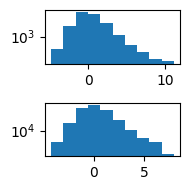

Adjusting learning rate of group 0 to 1.0000e-07.
(-0.6210335406912378, -0.6829267711524504)
---


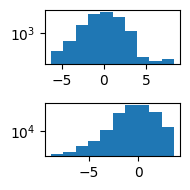

Adjusting learning rate of group 0 to 1.0000e-07.
(-0.7019331566540592, -0.7586700313062553)


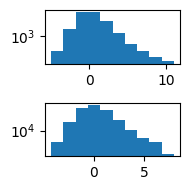

Adjusting learning rate of group 0 to 1.0000e-07.
(-0.626493539436754, -0.6827847842710564)
---


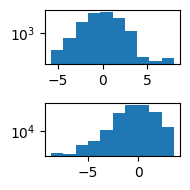

Adjusting learning rate of group 0 to 1.0000e-07.
(-0.7064312854445124, -0.7593248694776052)


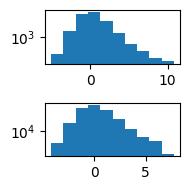

Adjusting learning rate of group 0 to 1.0000e-07.
(-0.6270951169082918, -0.6830487524170473)
---


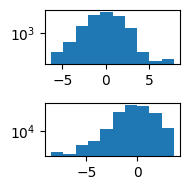

Adjusting learning rate of group 0 to 1.0000e-07.
(-0.7017416584204479, -0.7593345046043396)


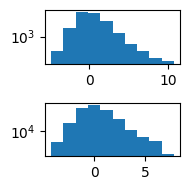

Adjusting learning rate of group 0 to 1.0000e-07.
(-0.6296493285391704, -0.6838780469205006)
---


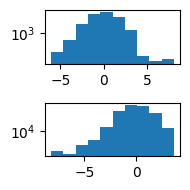

Adjusting learning rate of group 0 to 1.0000e-07.
(-0.7052569762769952, -0.7596955586628742)


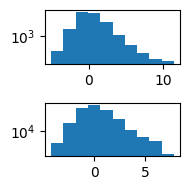

Adjusting learning rate of group 0 to 1.0000e-07.
(-0.6283637468355248, -0.6839170218950295)
---


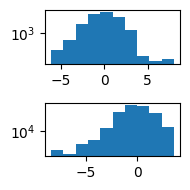

Adjusting learning rate of group 0 to 1.0000e-07.
(-0.7010805080813097, -0.7591214768857841)


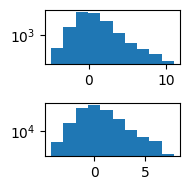

Adjusting learning rate of group 0 to 1.0000e-07.
(-0.625177008649671, -0.6840633333447468)
---


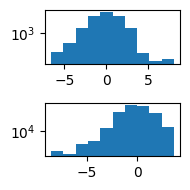

Adjusting learning rate of group 0 to 1.0000e-07.
(-0.7041300711143448, -0.7595216610345495)


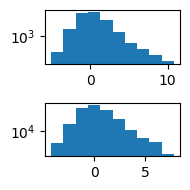

Adjusting learning rate of group 0 to 1.0000e-07.
(-0.6269593526081867, -0.6834551900266165)
---


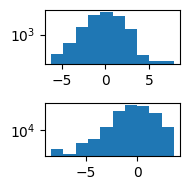

Adjusting learning rate of group 0 to 1.0000e-07.
(-0.7067611906901899, -0.759719124041408)


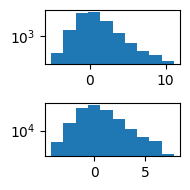

Adjusting learning rate of group 0 to 1.0000e-07.
(-0.6255957410637155, -0.6839425305286085)
---


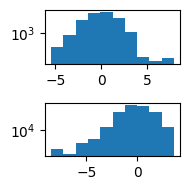

Adjusting learning rate of group 0 to 1.0000e-07.
(-0.7015568695693131, -0.7592885982559388)


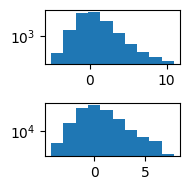

Adjusting learning rate of group 0 to 1.0000e-07.
(-0.6293275162398096, -0.6833729040191834)
---


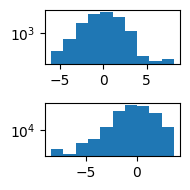

Adjusting learning rate of group 0 to 1.0000e-08.
(-0.7055470735193735, -0.7586476831551058)


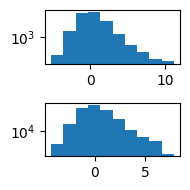

Adjusting learning rate of group 0 to 1.0000e-08.
(-0.629043482872377, -0.68414090340396)
---


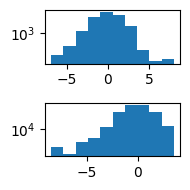

Adjusting learning rate of group 0 to 1.0000e-08.
(-0.7039966188281416, -0.7592509360198515)


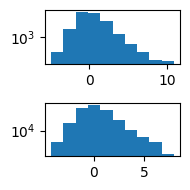

Adjusting learning rate of group 0 to 1.0000e-08.
(-0.622988776382373, -0.6838933703411056)
---


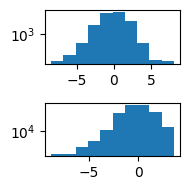

Adjusting learning rate of group 0 to 1.0000e-08.
(-0.6969697607389416, -0.759685155138912)


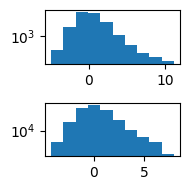

Adjusting learning rate of group 0 to 1.0000e-08.
(-0.6251911309110113, -0.6840341895459646)
---


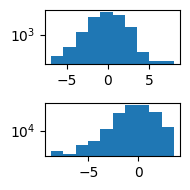

Adjusting learning rate of group 0 to 1.0000e-08.
(-0.7022292294416083, -0.7593898090971521)


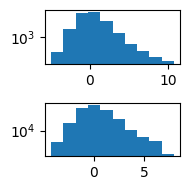

Adjusting learning rate of group 0 to 1.0000e-08.
(-0.619472709046789, -0.6841557715312544)
---


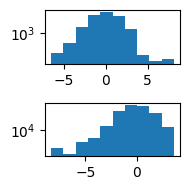

Adjusting learning rate of group 0 to 1.0000e-08.
(-0.7064193156828363, -0.758648975067828)


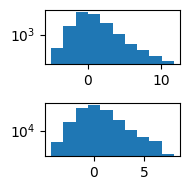

Adjusting learning rate of group 0 to 1.0000e-08.
(-0.6308245127459606, -0.6841330334364649)
---


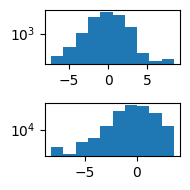

Adjusting learning rate of group 0 to 1.0000e-08.
(-0.7007131991257151, -0.759686437715967)


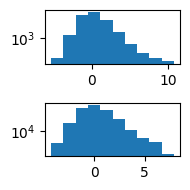

Adjusting learning rate of group 0 to 1.0000e-08.
(-0.626425710428192, -0.6838891621095589)
---


In [59]:
def train_for_one_epoch(nn, dataloader, ds_val, optimizer, scheduler, loss):
    losses = []
    losses_val = []
    res, res_val = [], []
    for x, y in dataloader:
        # training data
        nn.train()
        optimizer.zero_grad()
        y_hat = nn(x)
        loss_y_yhat = loss(y_hat, y)
        loss_y_yhat.backward()
        optimizer.step()
        losses.append(loss_y_yhat.item())
        res.append(loss.residuals(y_hat, y).detach().cpu().flatten())
        # validation data
        nn.eval()
        with torch.no_grad():
            y = ds_val[:][1]
            y_hat = nn(ds_val[:][0])
        res_val.append(loss.residuals(y_hat, y).detach().cpu().reshape((-1, )))
        loss_val = loss(y_hat, y).item()
        losses_val.append(loss_val)
    res = np.concatenate(res)
    res_val = np.concatenate(res_val)
    plt.figure(figsize=(2, 2))
    plt.subplot(2, 1, 1)
    plt.hist(res, log=True)
    plt.subplot(2, 1, 2)
    plt.hist(res_val, log=True)
    plt.tight_layout()
    plt.show()
    # call scheduler
    scheduler.step()
    return np.mean(losses), np.mean(losses_val)

%matplotlib inline

losses, losses_gaussian = [], []
for i in range(35):
    dl = DataLoader(torch_ds, batch_size=4096, shuffle=True)
    train_val_losses = train_for_one_epoch(nn, dl, torch_ds_val, optimizer, scheduler, loss)
    losses.append(train_val_losses)
    print(train_val_losses)
    train_val_losses = train_for_one_epoch(nn_gaussian, dl, torch_ds_val, 
                                               optimizer_gaussian, scheduler_gaussian, loss_gaussian)
    losses_gaussian.append(train_val_losses)
    print(train_val_losses)
    print('---')

### Models 

In [60]:
torch.save(nn.state_dict(), f'tukey_{CROP}_{LOG}_year.pth')
torch.save(nn_gaussian.state_dict(), f'gaussian_{CROP}_{LOG}_year.pth')

In [20]:
nn.load_state_dict(torch.load(f'tukey_{CROP}_{LOG}_year.pth'))
nn_gaussian.load_state_dict(torch.load(f'gaussian_{CROP}_{LOG}_year.pth'))

<All keys matched successfully>

## Validation data

In [29]:
nn.eval()
nn_gaussian.eval()

NNyear(
  (nn): NN(
    (0): Linear(in_features=2, out_features=256, bias=True)
    (1): ReLU()
    (2): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Linear(in_features=256, out_features=256, bias=True)
    (4): ReLU()
    (5): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): Linear(in_features=256, out_features=256, bias=True)
    (7): ReLU()
    (8): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): Linear(in_features=256, out_features=256, bias=True)
    (10): ReLU()
    (11): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (12): Linear(in_features=256, out_features=256, bias=True)
    (13): ReLU()
    (14): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (15): Linear(in_features=256, out_features=256, bias=True)
  )
  (l): Linear(in_features=257, out_features=64, bias=True)
  (l2): Lin

In [30]:
from torch.utils.data import DataLoader, TensorDataset
pred, res, res_gaussian = [], [], []

with torch.no_grad():
    data_loader = DataLoader(TensorDataset(features_val, targets_val), shuffle=False, batch_size=1024 * 10)
    for x, y in data_loader:
        pred.append(torch.cat(loss.predict(nn(x)), axis=-1).cpu().numpy())
        res.append(loss.residuals(nn(x), y).cpu().numpy())
        res_gaussian.append(loss_gaussian.residuals(nn_gaussian(x), y).cpu().numpy())

pred = np.concatenate(pred)
res = np.concatenate(res)
res_gaussian = np.concatenate(res_gaussian)

pred_mean = pred[:, 0]
pred_g = pred[:, 2]
pred_h = pred[:, 3]
pred_mean = mean_targets + pred_mean


lat_, lon_ = lat, lon


In [31]:
from scipy.stats import norm

lat_, lon_ = lat, lon
pred_mean = np.reshape(pred_mean, (len(years_val), lat_.shape[0], lon_.shape[1]))
pred_mean = np.where(~m, pred_mean, np.nan)

res = np.reshape(res, (len(years_val), lat_.shape[0], lon_.shape[1]))
res_u = norm.cdf(res)
#res[:, m] = np.nan

res_gaussian = np.reshape(res_gaussian, (len(years_val), lat_.shape[0], lon_.shape[1]))
#res_gaussian[:, m] = np.nan


In [32]:
res = res[:3, ...]
res_gaussian = res_gaussian[:3, ...]

In [33]:
res.shape

(3, 360, 720)

<IPython.core.display.Javascript object>


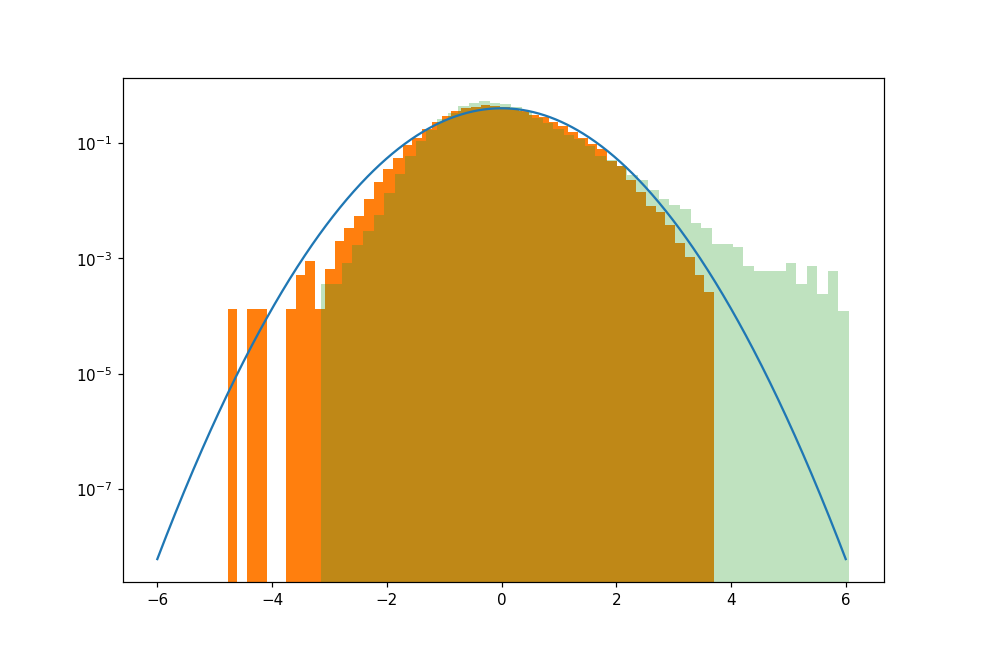

<IPython.core.display.Javascript object>


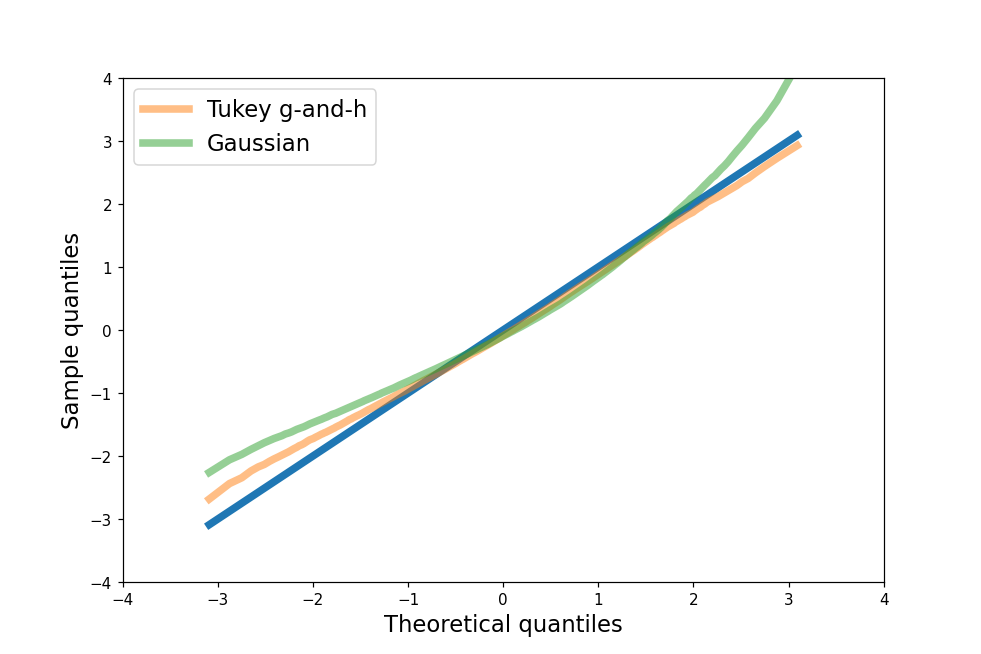

In [34]:
%matplotlib notebook

from scipy.stats import norm

n_quantiles = 1000
p_values = np.linspace(0, 1, 1000)[1:-1]
qs = np.nanquantile(res[:, ~m].flatten(), p_values)
qs_gaussian = np.nanquantile(res_gaussian[:, ~m], p_values)
qs_th = norm.ppf(p_values)

plt.figure()
plt.plot(np.linspace(-6, 6, n_quantiles), norm.pdf(np.linspace(-6, 6, n_quantiles)))
plt.hist(res.flatten(), bins=50, density=True, log=True)
plt.hist(res_gaussian.flatten(), bins=50, density=True, log=True, alpha=0.3)


plt.figure()
plt.plot(qs_th, qs_th, linewidth=5)
plt.plot(qs_th, qs, linewidth=5, alpha=0.5, label='Tukey g-and-h')
plt.plot(qs_th, qs_gaussian, linewidth=5, alpha=0.5, label='Gaussian')
plt.xlabel('Theoretical quantiles', fontsize=15)
plt.ylabel('Sample quantiles', fontsize=15)
plt.xlim(-4, 4)
plt.ylim(-4, 4)
plt.legend(fontsize=15)

plt.savefig(f'res_val_qq_plot_{CROP}.jpg', dpi=800)

In [35]:
res_gaussian.shape

(3, 360, 720)

<IPython.core.display.Javascript object>


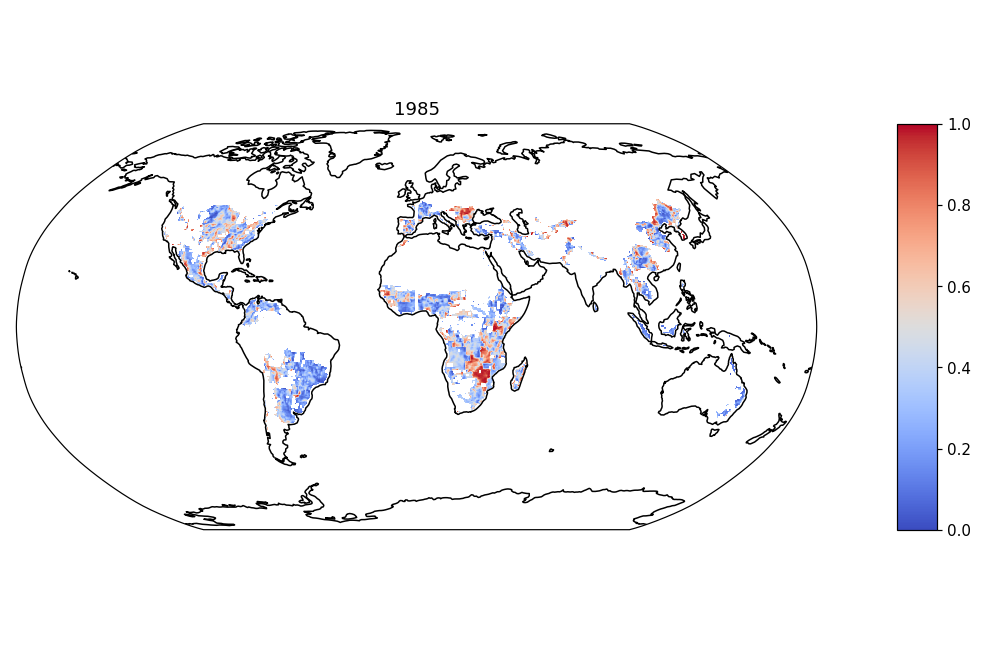

<IPython.core.display.Javascript object>


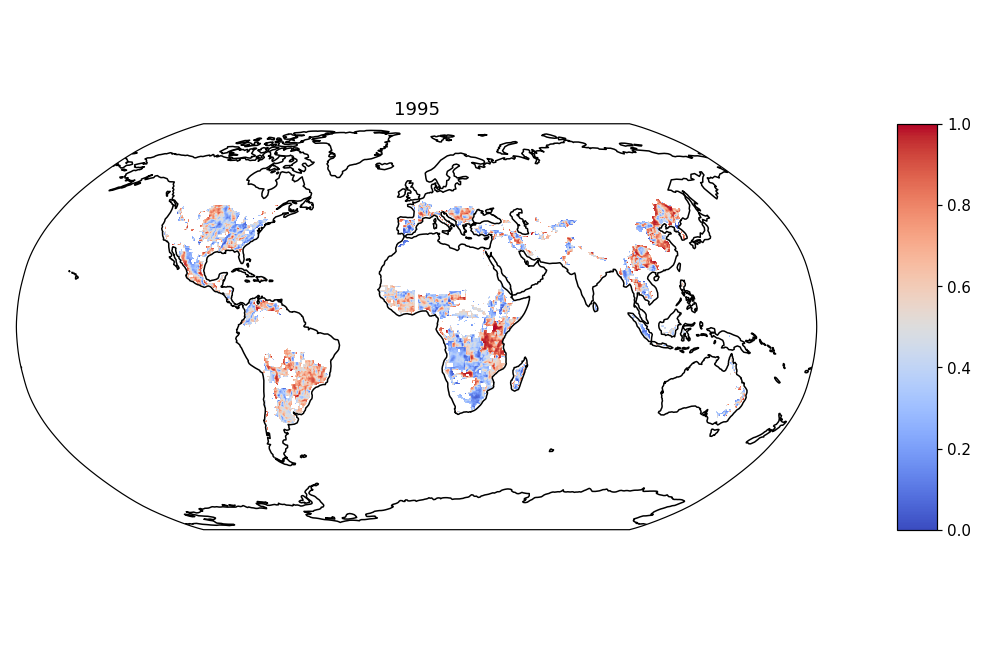

<IPython.core.display.Javascript object>


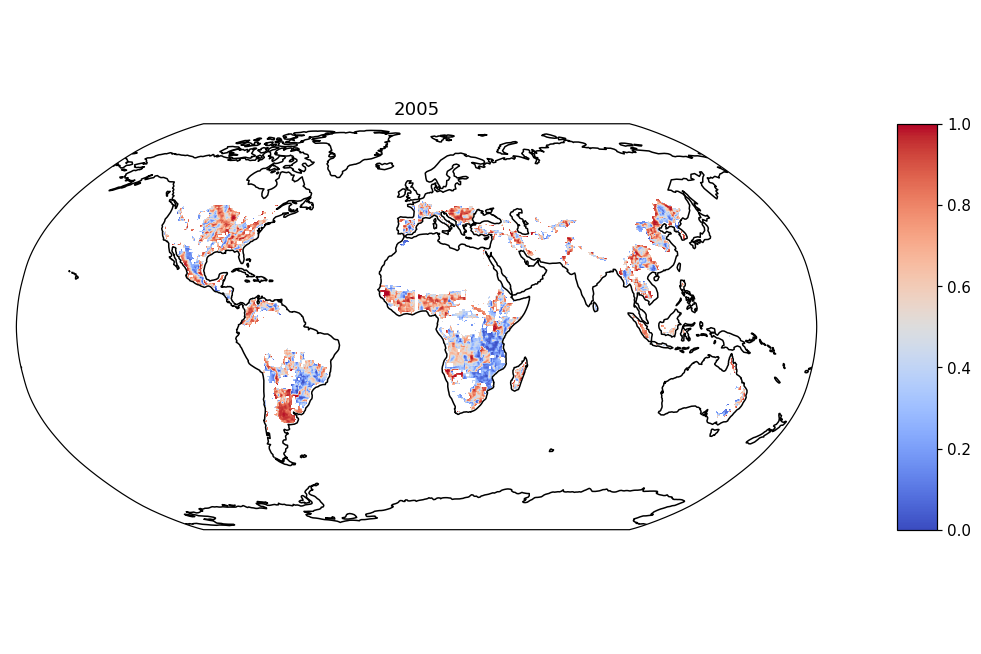

<IPython.core.display.Javascript object>


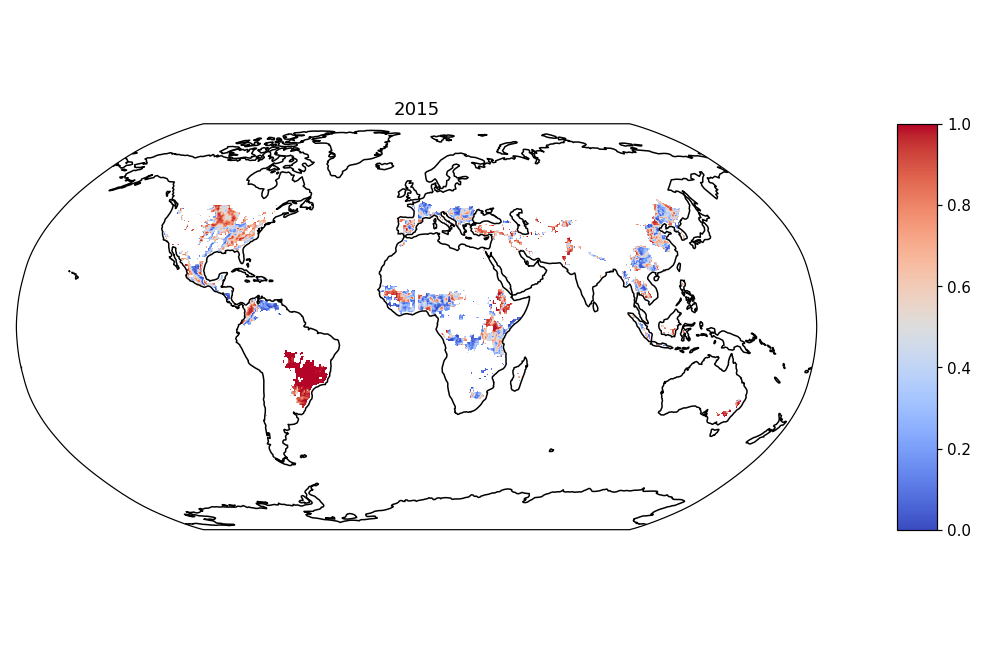

In [44]:
%matplotlib notebook
for i, year in enumerate(years_val):
    plot_on_map(res_u[i, ...], vmin=0, vmax=1, cmap='coolwarm')
    plt.title(year)
    plt.savefig(f'residual_val_map_{i}.jpg', dpi=800)

<IPython.core.display.Javascript object>


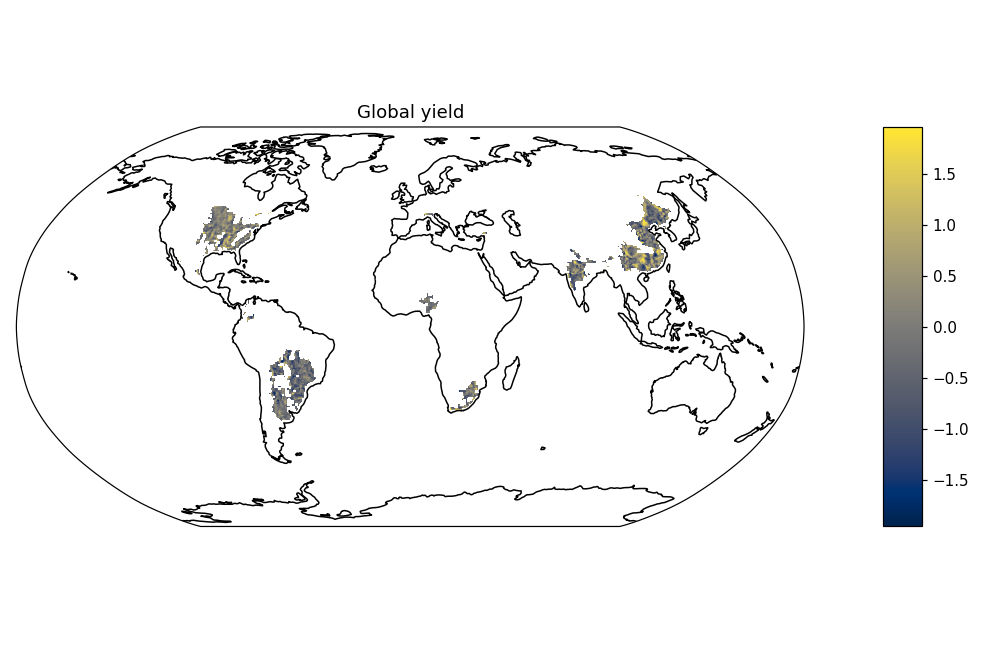

In [32]:
plot_on_map(np.mean(res, axis=0))

In [32]:
res.shape

(3, 360, 720)

In [33]:
np.nanstd(res), np.nanstd(np.mean(res, axis=0))

(0.8921663, 0.78097785)

<IPython.core.display.Javascript object>


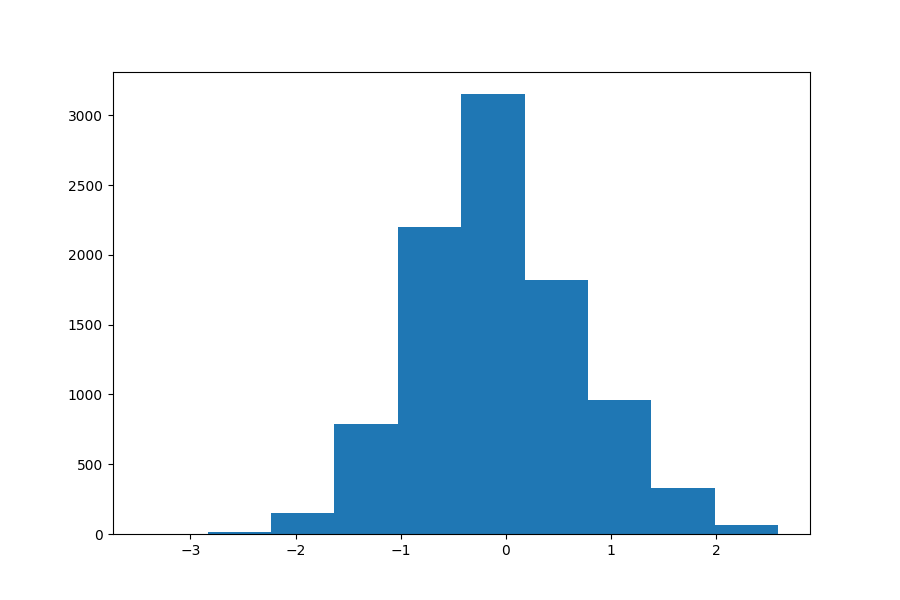

(array([2.000e+00, 1.400e+01, 1.540e+02, 7.910e+02, 2.203e+03, 3.153e+03,
        1.822e+03, 9.580e+02, 3.310e+02, 6.600e+01]),
 array([-3.43929863, -2.83644891, -2.23359942, -1.6307497 , -1.02789998,
        -0.42505038,  0.17779927,  0.78064895,  1.38349855,  1.98634827,
         2.58919787]),
 <BarContainer object of 10 artists>)

In [34]:
plt.figure()
plt.hist(np.mean(res, axis=0).flatten())

### Test data 

In [45]:
del features_val
del targets_val

In [49]:
from torch.utils.data import DataLoader, TensorDataset
pred, res, res_gaussian = [], [], []

with torch.no_grad():
    data_loader = DataLoader(TensorDataset(features_test, targets_test), shuffle=False, batch_size=1024 * 10)
    for x, y in data_loader:
        pred.append(torch.cat(loss.predict(nn(x)), axis=-1).cpu().numpy())
        res.append(loss.residuals(nn(x), y).cpu().numpy())
        res_gaussian.append(loss_gaussian.residuals(nn_gaussian(x), y).cpu().numpy())

pred = np.concatenate(pred)
res = np.concatenate(res)
res_gaussian = np.concatenate(res_gaussian)

pred_mean = pred[:, 0]
pred_g = pred[:, 2]
pred_h = pred[:, 3]
pred_mean = mean_targets + pred_mean


lat_, lon_ = lat, lon


In [50]:
pred_mean = np.reshape(pred_mean, (len(years_test), lat_.shape[0], lon_.shape[1]))
pred_mean = np.where(~m, pred_mean, np.nan)

pred_g = np.reshape(pred_g, (len(years_test), lat_.shape[0], lon_.shape[1]))
pred_g = np.where(~m, pred_g, np.nan)

pred_h = np.reshape(pred_h, (len(years_test), lat_.shape[0], lon_.shape[1]))
pred_h = np.where(~m, pred_h, np.nan)

res = np.reshape(res, (len(years_test), lat_.shape[0], lon_.shape[1]))
res[:, m] = np.nan
res_u = norm.cdf(res)

res_gaussian = np.reshape(res_gaussian, (len(years_test), lat_.shape[0], lon_.shape[1]))
res_gaussian[:, m] = np.nan


<IPython.core.display.Javascript object>


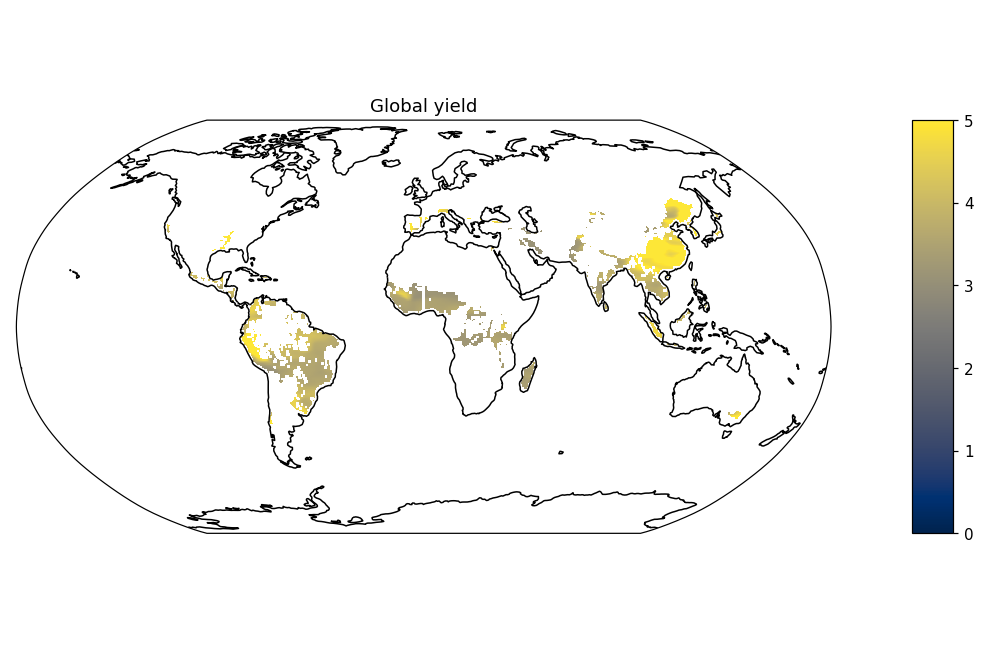

In [148]:
plot_on_map(pred_mean[0, ...], vmin=0, vmax=5)

<IPython.core.display.Javascript object>


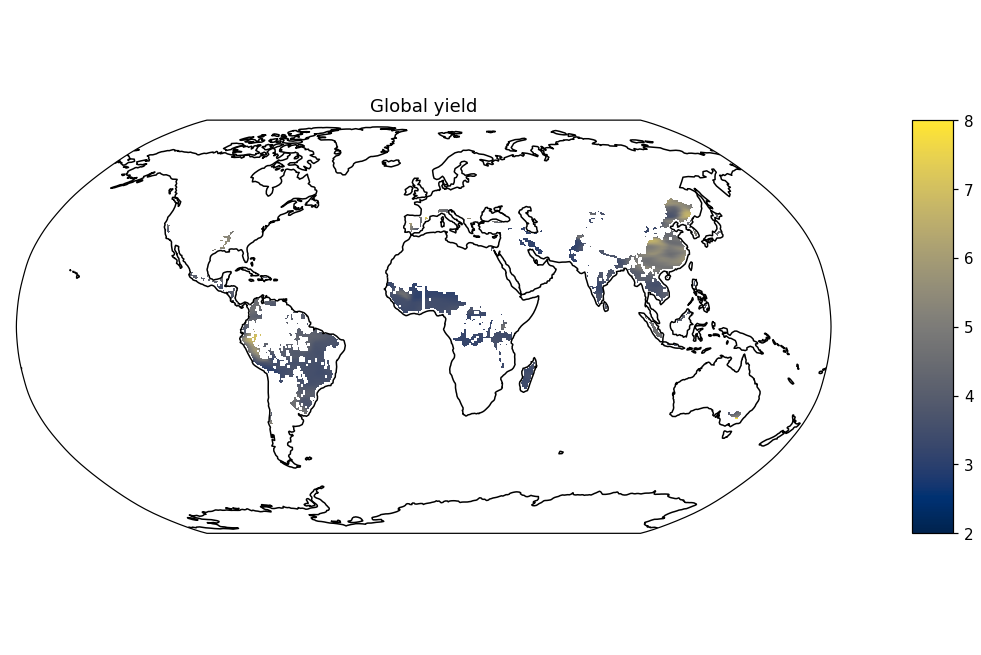

In [149]:
%matplotlib notebook
plot_on_map(pred_mean[0, ...], vmin=2, vmax=8)

<IPython.core.display.Javascript object>


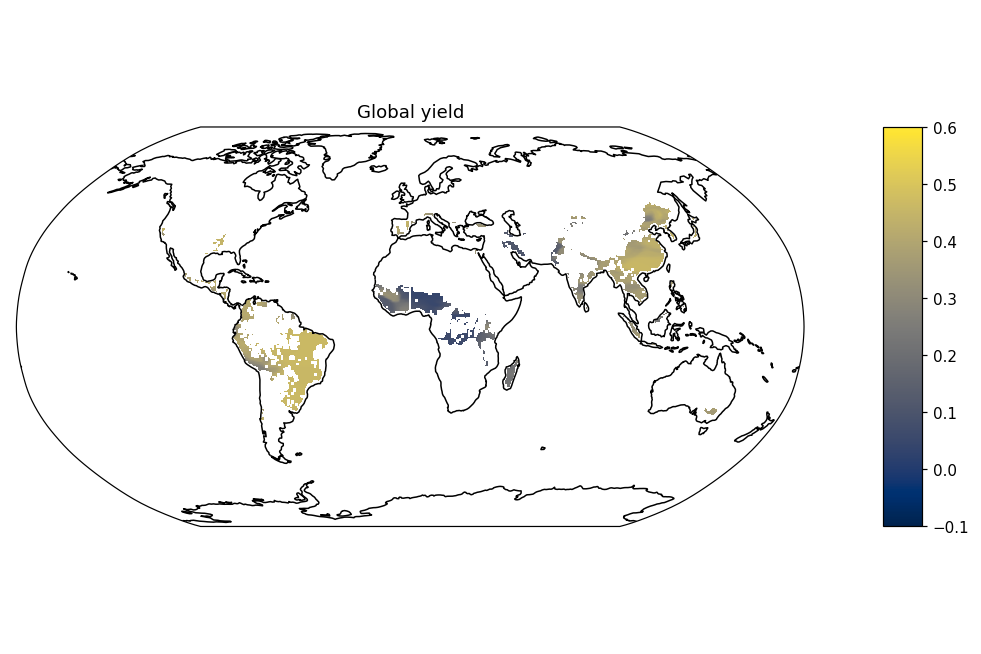

In [150]:
plot_on_map(pred_mean[-1, ...] - pred_mean[0, ...], vmin=-.1, vmax=.6)

<IPython.core.display.Javascript object>


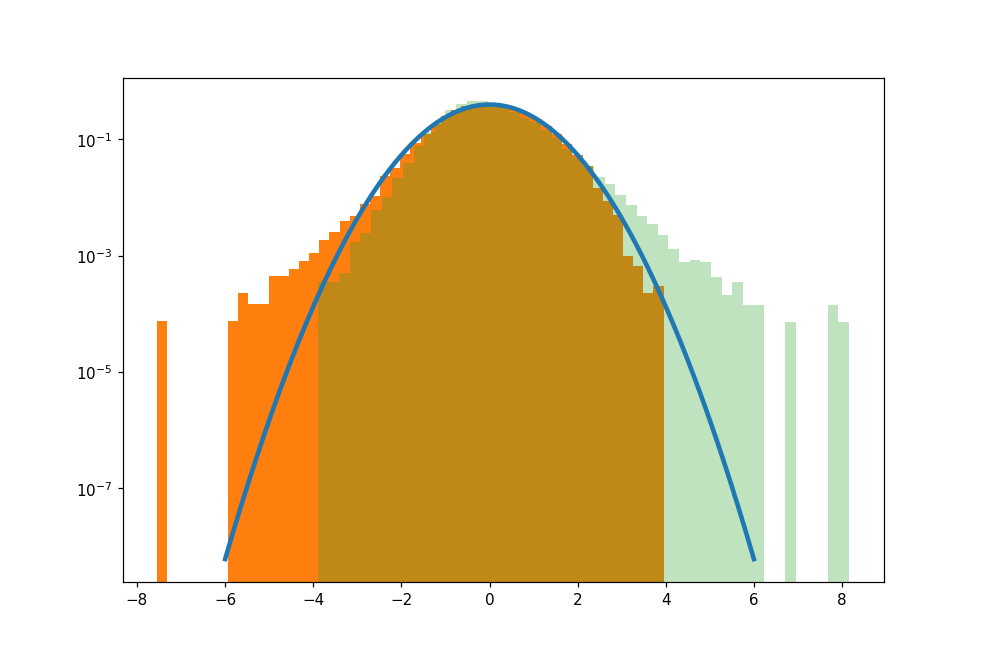

<IPython.core.display.Javascript object>


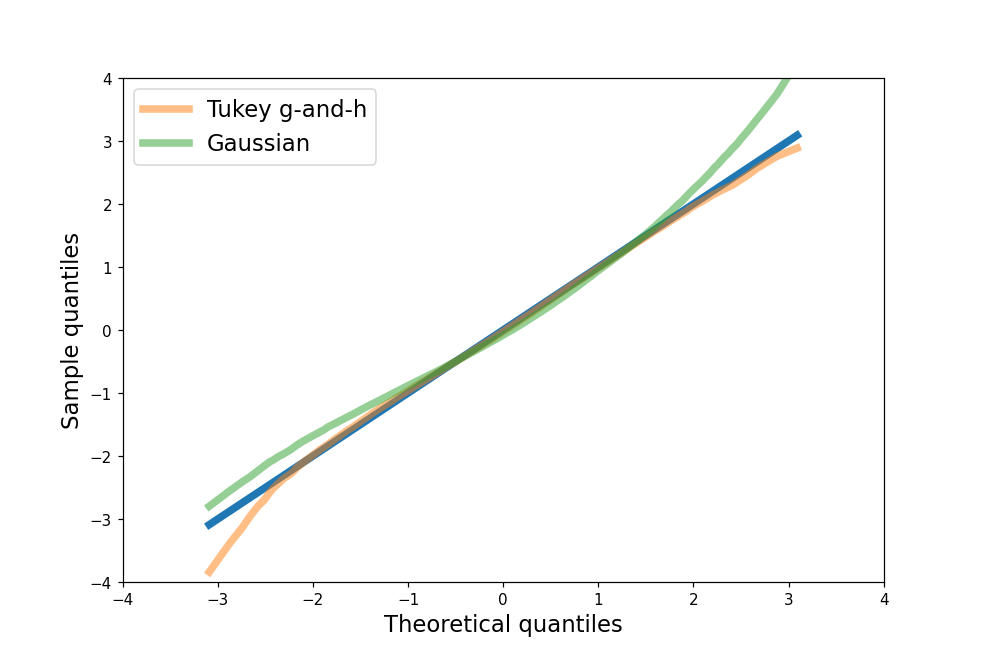

In [48]:
%matplotlib notebook

from scipy.stats import norm

qs = np.quantile(res[~np.isnan(res)], np.linspace(0, 1, 1000)[1:-1])
qs_gaussian = np.quantile(res_gaussian[~np.isnan(res_gaussian)], np.linspace(0, 1, 1000)[1:-1])
qs_th = norm.ppf(np.linspace(0, 1, 1000)[1:-1])

plt.figure()
plt.plot(np.linspace(-6, 6, 1000), norm.pdf(np.linspace(-6, 6, 1000)), linewidth=3)
plt.hist(res.flatten(), bins=50, density=True, log=True)
plt.hist(res_gaussian.flatten(), bins=50, density=True, log=True, alpha=0.3)


plt.figure()
plt.plot(qs_th, qs_th, linewidth=5)
plt.plot(qs_th, qs, linewidth=5, alpha=0.5, label='Tukey g-and-h')
plt.plot(qs_th, qs_gaussian, linewidth=5, alpha=0.5, label='Gaussian')
plt.xlabel('Theoretical quantiles', fontsize=15)
plt.ylabel('Sample quantiles', fontsize=15)
plt.xlim(-4, 4)
plt.ylim(-4, 4)
plt.legend(fontsize=15)

plt.savefig(f'res_test_qq_plot_{CROP}.jpg', dpi=800)

<IPython.core.display.Javascript object>


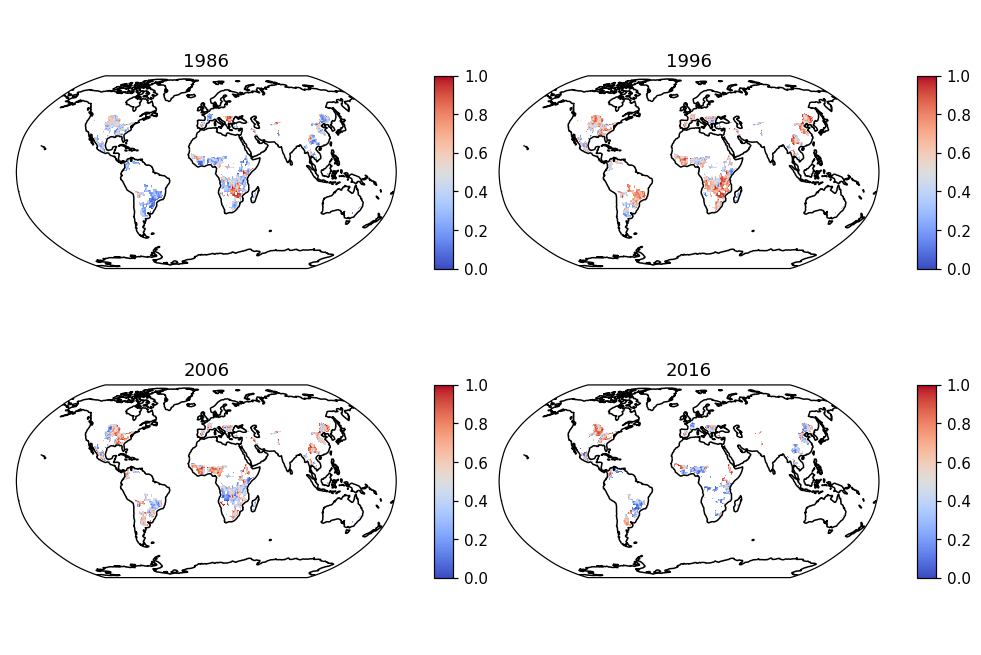

In [62]:
fig = plt.figure()

for i, year in enumerate(years_test):
    ax = fig.add_subplot(2, 2, i + 1, projection=ccrs.Robinson())
    plot_on_map(res_u[i, ...], vmin=0, vmax=1, cmap='coolwarm', ax=ax)
    plt.title(year)

fig.tight_layout()
plt.savefig(f'map_ures_test_{CROP}')

Mean of residuals

<IPython.core.display.Javascript object>


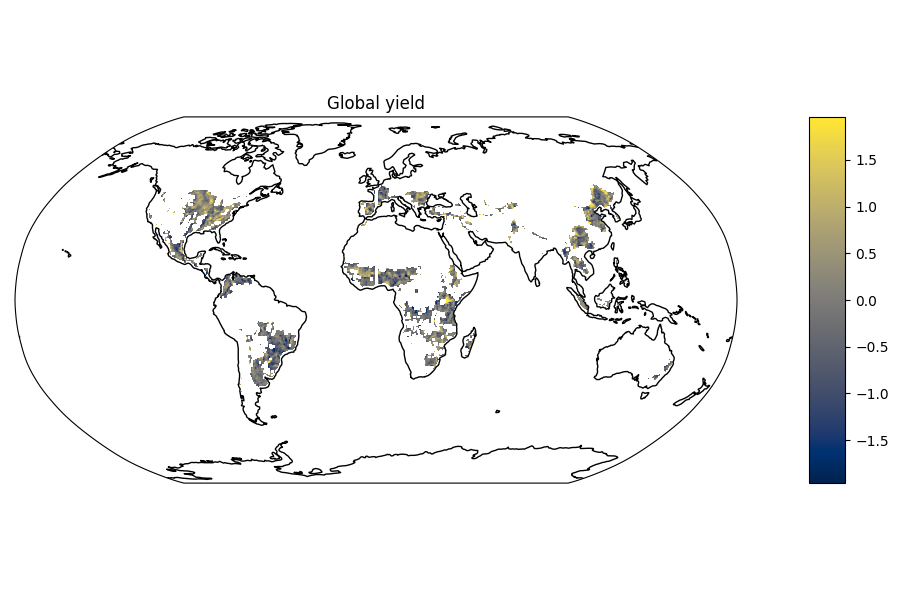

In [41]:
plot_on_map(np.mean(res, axis=0))

Plot predicted distribution at given location, for given year, and true value

<IPython.core.display.Javascript object>


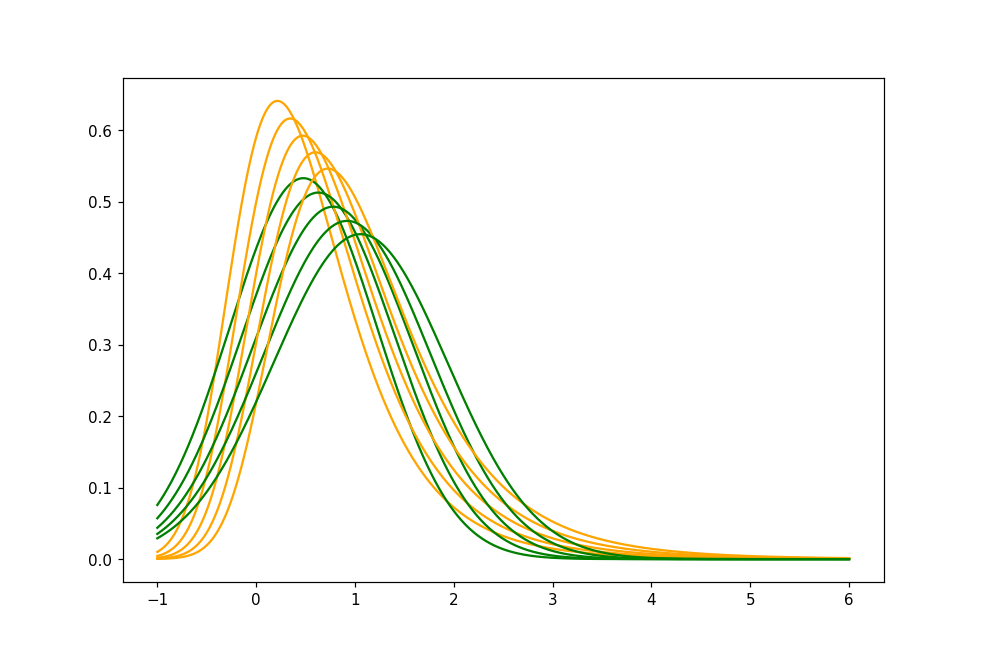

[0.4156012535095215, 1.519078016281128, 0.3526569604873657, 0.03084706887602806]
[0.47813865542411804, 1.3366475105285645]
[0.5581772327423096, 1.456534743309021, 0.36087632179260254, 0.029733406379818916]
[0.6290485858917236, 1.2861254215240479]
[0.7006410956382751, 1.3955574035644531, 0.3693021535873413, 0.02869880199432373]
[0.7798599004745483, 1.2365468740463257]
[0.8434878587722778, 1.3365356922149658, 0.3782445192337036, 0.02772134728729725]
[0.9208714962005615, 1.1866906881332397]
[0.9863346219062805, 1.2787301540374756, 0.38711678981781006, 0.026776734739542007]
[1.0569655895233154, 1.1400789022445679]


In [55]:
from tukey.utils import compute_pdf_tukey
from scipy.stats import norm

plt.figure()

lon, lat = -0.8 + 360, 41
#lon, lat = 33, 50

for year in range(2000, 2020, 4):
    dataa = np.array([lat, lon, year]).reshape((1, -1))
    dataa = (dataa - mean_features) / std_features
    dataa = torch.tensor(dataa, device=DEVICE, dtype=torch.float)

    xs = torch.linspace(-1, 6, 1000)
    ys1 = loss.predict(nn(dataa))
    ys1 = [k[0, 0].item() for k in ys1]
    print(ys1)
    ys2 = loss_gaussian.predict(nn_gaussian(dataa))
    ys2 = [k[0, 0].item() for k in ys2]
    print(ys2)

    dist = norm(ys2[0], 1 / ys2[1])
    plt.plot(xs, compute_pdf_tukey(xs, ys1[2], ys1[3], ys1[0], 1 / ys1[1]), color='orange')
    #plt.plot(xs, compute_pdf_tukey(xs, 0.00001, 0.2, 0, 1))
    plt.plot(xs, dist.pdf(xs), color='green')